<a href="https://colab.research.google.com/github/fallenmorningstar/PandasLearningFMS/blob/master/NN_4_weeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<footer id="footer"></footer>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

<h1 align='center'>Классификация изображений с pyTorch Lightning </h1>

## Загрузка данных c Kaggle



[Weather dataset](https://www.kaggle.com/datasets/jehanbhathena/weather-dataset) - ссылка на датасет  
[API-kaggle](https://www.kaggle.com/docs/api) - дополнительная информация об API

In [ ]:
# установка API
!pip install -q kaggle

In [ ]:
# модный widget загрузки
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bogdanovnikolay","key":"24f0f1fd5d0e605609e99913b8f6a199"}'}

[chmod-калькулятор](https://chmod-calculator.com/)

In [ ]:
# создаем директорию kaggle и копируем файл в нее, 
# добавляя разрешение на запись и чтение
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# список датасетов
!kaggle datasets list

ref                                                        title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide       Covid Cases and Deaths WorldWide             8KB  2023-02-01 12:22:51           5110        148  1.0              
datascientistanna/customers-dataset                        Shop Customer Data                          23KB  2023-02-07 18:42:21           3825         99  1.0              
rajugc/imdb-top-250-movies-dataset                         IMDB Top 250 Movies Dataset                 52KB  2023-02-11 16:02:01           1642         49  1.0              
ahsan81/hotel-reservations-classification-dataset          Hotel Reservations Dataset                 480KB  2023-01-04 12:50:31  

```python
https://www.kaggle.com/datasets/jehanbhathena/weather-dataset

```

In [ ]:
# список датасетов с ключевым словом поиска
!kaggle datasets list -s "weed-types"

ref                                                             title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
bogdanovnikolay/weed-types                                      weed types                                         13GB  2023-02-21 04:03:32             11          1  0.1875           
ravirajsinh45/crop-and-weed-detection-data-with-bounding-boxes  crop and weed detection data with bounding boxes   79MB  2020-04-06 10:06:46           4606         76  0.9375           
thedevastator/weed-plant-taxonomy-in-france-and-uk              Weeds In Cultivation Fields                        46KB  2023-01-31 08:10:44            260         17  0.9411765        
vvatsalggupta/weed-detection                                    Weed D

In [ ]:
# скачиваем сет
!kaggle datasets download -d "bogdanovnikolay/weed-types"

100% 13.3G/13.3G [11:36<00:00, 23.8MB/s]
100% 13.3G/13.3G [11:36<00:00, 20.6MB/s]


In [ ]:
%%capture
# распаковка сета
!unzip weed-types.zip

In [ ]:
# удаляем лишнее
!rm weed-types.zip

In [ ]:
!mv -i dataset2/* dataset
!mv -i dataset3/* dataset

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/Наверх-&#x21A9-blue'></a>
</div>

___


## Подготовка



[ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html) - пример сета с изображениями, оффициальная документация `pyTorch`  
[Аугментации pyTorch](https://pytorch.org/vision/stable/transforms.html) - список аугментаций `pyTorch`  
[ImageNet](https://paperswithcode.com/dataset/imagenet) - описание сета `ImageNet` и [тут](https://www.image-net.org/about.php)   
[EfficientNet](https://github.com/lukemelas/EfficientNet-PyTorch) - ссылка на репозиторий с семейством EfficientNet

In [ ]:
!pip install -q split-folders pytorch_lightning efficientnet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 KB 43.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 46.3 MB/s eta 0:00:00


In [ ]:
# библиотеки для работы с изображениями
import cv2
from PIL import Image
import numpy as np
# библиотека для работы с путями
from pathlib import Path
# вспомогательные
import matplotlib.pyplot as plt
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# для работы
import torch
import torch.nn as nn
import torch.nn.functional as F
import splitfolders
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torchmetrics import Accuracy
from efficientnet_pytorch import EfficientNet


# автоматическое логивароение результатов
from pytorch_lightning.loggers import TensorBoardLogger
# сохранение весов
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
# автоматическое отслеживание lr
from pytorch_lightning.callbacks import LearningRateMonitor
# ранние остановки
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# дополнительные импорты
from tqdm.autonotebook import tqdm
from sklearn.metrics import classification_report
import warnings


# сахар опционально :
SEED = 42
pl.seed_everything(SEED)
plt.style.use('dark_background')
warnings.filterwarnings("ignore")

INFO:lightning_fabric.utilities.seed:Global seed set to 42


In [ ]:
DATASET = Path("/content/dataset")

In [ ]:
# пробегаем по директории с картинками и добавляем в список
images = [p.resolve() for p in DATASET.glob("**/*") if p.suffix in {".png", ".jpg", ".jpeg"}]

In [ ]:
images[:3]

[PosixPath('/content/dataset/China_klubnenosnaya/1a304322-819f-679f-0772-eb1339a10aab.jpg'),
 PosixPath('/content/dataset/China_klubnenosnaya/747344f2-85c9-87d9-16c3-cef6381078ba.jpg'),
 PosixPath('/content/dataset/China_klubnenosnaya/da3144c8-fcf4-6536-1406-36117d09b9a1.jpg')]

In [ ]:
len(images)

5148

In [ ]:
sample_idx = np.random.randint(len(images))

In [ ]:
sample_idx

860

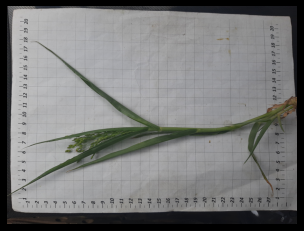

In [ ]:
img = Image.open(images[sample_idx]) # RGB!
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
# img = cv2.imread(str(images[sample_idx])) # BGR!
# plt.imshow(img[...,::-1]) # BGR -> RGB
# plt.axis("off")
# plt.show()

# Разбивка сета с изображениями

In [ ]:
splitfolders.ratio(
                    "/content/dataset",
                    output="weed_split",
                    seed=42,
                    ratio=(.8, .1, .1),
                    group_prefix=None,
                    move=False
)

Copying files: 5148 files [01:30, 56.60 files/s]


In [ ]:
images = [p.resolve() for p in Path("/content/weed_split").glob("**/*") if p.suffix in {".png", ".jpg", ".jpeg"}]
len(images)

5148

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/Наверх-&#x21A9-blue'></a>
</div>

___


# Datamodule для загрузки данных

In [ ]:
class ImgDataModule(pl.LightningDataModule):
  def __init__(self, 
               batch_size = 1,
               train_transform=None,
               val_transform=None,
               img_root = 'weed_split'
               ):
    super().__init__()
    self.batch_size = batch_size
    self.train_transform = train_transform
    self.val_transform = val_transform
    self.img_root = img_root

  def setup(self, stage=None):
    # метод содержит информацию о датасете
    self.train_set = ImageFolder(self.img_root / Path("train"), transform=self.train_transform)
    self.val_set = ImageFolder(self.img_root / Path("val"), transform=self.val_transform)
    self.test_set = ImageFolder(self.img_root / Path("test"), transform=self.val_transform)

  def train_dataloader(self):
    # метод создает загрузчик
    return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=2)

  def val_dataloader(self):
    return DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=2)

  def test_dataloader(self):
    return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=2)

In [ ]:
dm = ImgDataModule()

In [ ]:
!rm weed_split/val/Diskutainiya_Sofiy/*
!rmdir weed_split/val/Diskutainiya_Sofiy
!rm weed_split/test/Diskutainiya_Sofiy/*
!rmdir weed_split/test/Diskutainiya_Sofiy
!rm weed_split/train/Diskutainiya_Sofiy/*
!rmdir weed_split/train/Diskutainiya_Sofiy

!rm weed_split/val/Durnishnik_zobovidniy/*
!rmdir weed_split/val/Durnishnik_zobovidniy
!rm weed_split/test/Durnishnik_zobovidniy/*
!rmdir weed_split/test/Durnishnik_zobovidniy
!rm weed_split/train/Durnishnik_zobovidniy/*
!rmdir weed_split/train/Durnishnik_zobovidniy

!rm weed_split/val/Horispora_nezhnaya/*
!rmdir weed_split/val/Horispora_nezhnaya
!rm weed_split/test/Horispora_nezhnaya/*
!rmdir weed_split/test/Horispora_nezhnaya
!rm weed_split/train/Horispora_nezhnaya/*
!rmdir weed_split/train/Horispora_nezhnaya

!rm weed_split/val/Nezabudka_polevaya/*
!rmdir weed_split/val/Nezabudka_polevaya
!rm weed_split/test/Nezabudka_polevaya/*
!rmdir weed_split/test/Nezabudka_polevaya
!rm weed_split/train/Nezabudka_polevaya/*
!rmdir weed_split/train/Nezabudka_polevaya

!rm weed_split/val/Paslenovie/*
!rmdir weed_split/val/Paslenovie
!rm weed_split/test/Paslenovie/*
!rmdir weed_split/test/Paslenovie
!rm weed_split/train/Paslenovie/*
!rmdir weed_split/train/Paslenovie

!rm weed_split/val/Podorozhnik/*
!rmdir weed_split/val/Podorozhnik
!rm weed_split/test/Podorozhnik/*
!rmdir weed_split/test/Podorozhnik
!rm weed_split/train/Podorozhnik/*
!rmdir weed_split/train/Podorozhnik


#  Diskutainiya_Sofiy, Durnishnik_zobovidniy, Horispora_nezhnaya, Nezabudka_polevaya, Paslenovie, Podorozhnik
#

rm: cannot remove 'weed_split/val/Diskutainiya_Sofiy/*': No such file or directory
rm: cannot remove 'weed_split/train/Diskutainiya_Sofiy/*': No such file or directory
rm: cannot remove 'weed_split/val/Durnishnik_zobovidniy/*': No such file or directory
rm: cannot remove 'weed_split/train/Durnishnik_zobovidniy/*': No such file or directory
rm: cannot remove 'weed_split/val/Horispora_nezhnaya/*': No such file or directory
rm: cannot remove 'weed_split/train/Horispora_nezhnaya/*': No such file or directory
rm: cannot remove 'weed_split/val/Nezabudka_polevaya/*': No such file or directory
rm: cannot remove 'weed_split/train/Nezabudka_polevaya/*': No such file or directory
rm: cannot remove 'weed_split/val/Paslenovie/*': No such file or directory
rm: cannot remove 'weed_split/train/Paslenovie/*': No such file or directory
rm: cannot remove 'weed_split/val/Podorozhnik/*': No such file or directory
rm: cannot remove 'weed_split/train/Podorozhnik/*': No such file or directory


In [ ]:
!rm weed_split/val/Ambroziya_polinnolistnaya/*
!rmdir weed_split/val/Ambroziya_polinnolistnaya
!rm weed_split/test/Ambroziya_polinnolistnaya/*
!rmdir weed_split/test/Ambroziya_polinnolistnaya
!rm weed_split/train/Ambroziya_polinnolistnaya/*
!rmdir weed_split/train/Ambroziya_polinnolistnaya

!rm weed_split/val/Gorchak_polzuchiy/*
!rmdir weed_split/val/Gorchak_polzuchiy
!rm weed_split/test/Gorchak_polzuchiy/*
!rmdir weed_split/test/Gorchak_polzuchiy
!rm weed_split/train/Gorchak_polzuchiy/*
!rmdir weed_split/train/Gorchak_polzuchiy

!rm weed_split/val/Goroshek_volosistiy/*
!rmdir weed_split/val/Goroshek_volosistiy
!rm weed_split/test/Goroshek_volosistiy/*
!rmdir weed_split/test/Goroshek_volosistiy
!rm weed_split/train/Goroshek_volosistiy/*
!rmdir weed_split/train/Goroshek_volosistiy

!rm weed_split/val/Ikotnik_sedoi_seriy/*
!rmdir weed_split/val/Ikotnik_sedoi_seriy
!rm weed_split/test/Ikotnik_sedoi_seriy/*
!rmdir weed_split/test/Ikotnik_sedoi_seriy
!rm weed_split/train/Ikotnik_sedoi_seriy/*
!rmdir weed_split/train/Ikotnik_sedoi_seriy

!rm weed_split/val/Klopovnik_musorniy/*
!rmdir weed_split/val/Klopovnik_musorniy
!rm weed_split/test/Klopovnik_musorniy/*
!rmdir weed_split/test/Klopovnik_musorniy
!rm weed_split/train/Klopovnik_musorniy/*
!rmdir weed_split/train/Klopovnik_musorniy

!rm weed_split/val/Kohiya_Bassiya_venichnaya/*
!rmdir weed_split/val/Kohiya_Bassiya_venichnaya
!rm weed_split/test/Kohiya_Bassiya_venichnaya/*
!rmdir weed_split/test/Kohiya_Bassiya_venichnaya
!rm weed_split/train/Kohiya_Bassiya_venichnaya/*
!rmdir weed_split/train/Kohiya_Bassiya_venichnaya

!rm weed_split/val/Konoplya_sornaya/*
!rmdir weed_split/val/Konoplya_sornaya
!rm weed_split/test/Konoplya_sornaya/*
!rmdir weed_split/test/Konoplya_sornaya
!rm weed_split/train/Konoplya_sornaya/*
!rmdir weed_split/train/Konoplya_sornaya

!rm weed_split/val/Lipuchka_ottopirennaya/*
!rmdir weed_split/val/Lipuchka_ottopirennaya
!rm weed_split/test/Lipuchka_ottopirennaya/*
!rmdir weed_split/test/Lipuchka_ottopirennaya
!rm weed_split/train/Lipuchka_ottopirennaya/*
!rmdir weed_split/train/Lipuchka_ottopirennaya

!rm weed_split/val/Lebeda_rozovaya/*
!rmdir weed_split/val/Lebeda_rozovaya
!rm weed_split/test/Lebeda_rozovaya/*
!rmdir weed_split/test/Lebeda_rozovaya
!rm weed_split/train/Lebeda_rozovaya/*
!rmdir weed_split/train/Lebeda_rozovaya

!rm weed_split/val/Melkolepestnik_kanadskiy/*
!rmdir weed_split/val/Melkolepestnik_kanadskiy
!rm weed_split/test/Melkolepestnik_kanadskiy/*
!rmdir weed_split/test/Melkolepestnik_kanadskiy
!rm weed_split/train/Melkolepestnik_kanadskiy/*
!rmdir weed_split/train/Melkolepestnik_kanadskiy

!rm weed_split/val/Odnoletnie_zlakovie/*
!rmdir weed_split/val/Odnoletnie_zlakovie
!rm weed_split/test/Odnoletnie_zlakovie/*
!rmdir weed_split/test/Odnoletnie_zlakovie
!rm weed_split/train/Odnoletnie_zlakovie/*
!rmdir weed_split/train/Odnoletnie_zlakovie

!rm weed_split/val/Padalitsa_goroha/*
!rmdir weed_split/val/Padalitsa_goroha
!rm weed_split/test/Padalitsa_goroha/*
!rmdir weed_split/test/Padalitsa_goroha
!rm weed_split/train/Padalitsa_goroha/*
!rmdir weed_split/train/Padalitsa_goroha

!rm weed_split/val/Padalitsa_kukuruzy/*
!rmdir weed_split/val/Padalitsa_kukuruzy
!rm weed_split/test/Padalitsa_kukuruzy/*
!rmdir weed_split/test/Padalitsa_kukuruzy
!rm weed_split/train/Padalitsa_kukuruzy/*
!rmdir weed_split/train/Padalitsa_kukuruzy

!rm weed_split/val/Padalitsa_rapsa/*
!rmdir weed_split/val/Padalitsa_rapsa
!rm weed_split/test/Padalitsa_rapsa/*
!rmdir weed_split/test/Padalitsa_rapsa
!rm weed_split/train/Padalitsa_rapsa/*
!rmdir weed_split/train/Padalitsa_rapsa

!rm weed_split/val/Padalitsa_rzhi/*
!rmdir weed_split/val/Padalitsa_rzhi
!rm weed_split/test/Padalitsa_rzhi/*
!rmdir weed_split/test/Padalitsa_rzhi
!rm weed_split/train/Padalitsa_rzhi/*
!rmdir weed_split/train/Padalitsa_rzhi

!rm weed_split/val/Padalitsa_soi/*
!rmdir weed_split/val/Padalitsa_soi
!rm weed_split/test/Padalitsa_soi/*
!rmdir weed_split/test/Padalitsa_soi
!rm weed_split/train/Padalitsa_soi/*
!rmdir weed_split/train/Padalitsa_soi

!rm weed_split/val/Padalitsa_sudanskoi_travy/*
!rmdir weed_split/val/Padalitsa_sudanskoi_travy
!rm weed_split/test/Padalitsa_sudanskoi_travy/*
!rmdir weed_split/test/Padalitsa_sudanskoi_travy
!rm weed_split/train/Padalitsa_sudanskoi_travy/*
!rmdir weed_split/train/Padalitsa_sudanskoi_travy

!rm weed_split/val/Padalitsa_tritikale/*
!rmdir weed_split/val/Padalitsa_tritikale
!rm weed_split/test/Padalitsa_tritikale/*
!rmdir weed_split/test/Padalitsa_tritikale
!rm weed_split/train/Padalitsa_tritikale/*
!rmdir weed_split/train/Padalitsa_tritikale

!rm weed_split/val/Padalitsa_yachmenya/*
!rmdir weed_split/val/Padalitsa_yachmenya
!rm weed_split/test/Padalitsa_yachmenya/*
!rmdir weed_split/test/Padalitsa_yachmenya
!rm weed_split/train/Padalitsa_yachmenya/*
!rmdir weed_split/train/Padalitsa_yachmenya

# Ambroziya_polinnolistnaya, Gorchak_polzuchiy, Goroshek_volosistiy, Ikotnik_sedoi_seriy, Klopovnik_musorniy, Kohiya_Bassiya_venichnaya, 
# Konoplya_sornaya, Lebeda_rozovaya, Lipuchka_ottopirennaya, Melkolepestnik_kanadskiy, Odnoletnie_zlakovie,  Padalitsa_goroha, 
# Padalitsa_kukuruzy, Padalitsa_rapsa, Padalitsa_rzhi, Padalitsa_soi, Padalitsa_sudanskoi_travy, Padalitsa_tritikale, Padalitsa_yachmenya

rm: cannot remove 'weed_split/val/Ambroziya_polinnolistnaya/*': No such file or directory
rm: cannot remove 'weed_split/val/Gorchak_polzuchiy/*': No such file or directory
rm: cannot remove 'weed_split/val/Goroshek_volosistiy/*': No such file or directory
rm: cannot remove 'weed_split/val/Ikotnik_sedoi_seriy/*': No such file or directory
rm: cannot remove 'weed_split/val/Klopovnik_musorniy/*': No such file or directory
rm: cannot remove 'weed_split/val/Kohiya_Bassiya_venichnaya/*': No such file or directory
rm: cannot remove 'weed_split/val/Konoplya_sornaya/*': No such file or directory
rm: cannot remove 'weed_split/val/Lipuchka_ottopirennaya/*': No such file or directory
rm: cannot remove 'weed_split/val/Lebeda_rozovaya/*': No such file or directory
rm: cannot remove 'weed_split/val/Melkolepestnik_kanadskiy/*': No such file or directory
rm: cannot remove 'weed_split/val/Odnoletnie_zlakovie/*': No such file or directory
rm: cannot remove 'weed_split/val/Padalitsa_goroha/*': No such fil

In [ ]:
dm.setup()

In [ ]:
{k:v for k, v in enumerate(dm.test_set.classes)}

{0: 'Aistnik_tsikutoviy',
 1: 'Bodyak_polevoi',
 2: 'China_klubnenosnaya',
 3: 'Gorchitsa_polevaya',
 4: 'Goroshek_mishiniy',
 5: 'Gortsy_vidy',
 6: 'Grechiha_tatarskaya',
 7: 'Kermek_shirokolistniy',
 8: 'Konskiy_shavel',
 9: 'Kuray',
 10: 'Kurinoe_proso',
 11: 'Lebeda_Kopielistnaya',
 12: 'Lebeda_raskidistaya',
 13: 'Lipuchka_ezhevidnaya',
 14: 'Lnyanka_obiknovennaya',
 15: 'Mar_belaya',
 16: 'Molochai_lozniy',
 17: 'Molokan_tataskiy',
 18: 'Noneya_temno_buraya',
 19: 'Oduvanchik_lekarstvenniy',
 20: 'Osot_polevoi',
 21: 'Ovsug_obiknovenniy',
 22: 'Padalica_pshenitsy',
 23: 'Padalitsa_Lna',
 24: 'Padalitsa_chechevitsy',
 25: 'Padalitsa_podsolnechnika',
 26: 'Pastushya_sumka',
 27: 'Podmarennik_tsepkiy',
 28: 'Polyn_gorkaya',
 29: 'Polyn_polevaya',
 30: 'Prosovidnie_sornyaki'}

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/Наверх-&#x21A9-blue'></a>
</div>

___


# Создание модели pyTorchLightning

In [ ]:
class EffNetClassifier(pl.LightningModule):
  # обязательный метод
  def __init__(self,
               model = "efficientnet-b0",
               in_channels = 3,
               out_classes = 31,
               eta = 3e-4,
               **kwargs):
    super().__init__()
    self.save_hyperparameters()
    self.model = EfficientNet.from_pretrained(model,
                                              num_classes = out_classes,
                                              in_channels = in_channels)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    self.out_classes = out_classes
    self.criterion = nn.CrossEntropyLoss()
    # self.metrics = {"accuracy": Accuracy().to(device)}
    self.metrics = {"accuracy": Accuracy(task='multiclass', num_classes=out_classes).to(device)}

  # обязательный метод
  def forward(self, x):
    return self.model(x)
  # метод общий для всех
  def shared_step(self,
                  sample, 
                  stage):
    x, y = sample
    logits = self.forward(x.to(torch.float32))
    preds = torch.argmax(logits, 1)
    loss = self.criterion(logits, y.to(torch.int64))

    return {
            'loss': loss,
            'accuracy': self.metrics["accuracy"](preds, y)
    }
  # метод общий для всех
  def shared_epoch_end(self,
                       outputs,
                       stage):
    loss = np.mean([x["loss"].item() for x in outputs])
    acc = np.mean([x["accuracy"].item() for x in outputs])

    metrics = {
        
        f"{stage}_loss": loss,
        f"{stage}_acc": acc
    }

    self.log_dict(metrics, prog_bar=True)
  # обязательный шаг - создаем оптимизатор, BONUS - шедулер
  def configure_optimizers(self):
    optimizer = torch.optim.SGD(
        self.parameters(),
        lr = self.hparams.eta
    )

    scheduler_dict = {
        
        "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
            
            optimizer,
            patience=5
        ),
        "interval": "epoch",
        "monitor": "valid_loss"


    }
    return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}
  # шаг обучения
  def training_step(self,
                    batch,
                    batch_idx):
    return self.shared_step(batch, 'train')
  # шаг подсчета метрик обучения
  def training_epoch_end(self,
                    outputs):
    return self.shared_epoch_end(outputs, 'train')
  # шаг валидации
  def validation_step(self,
                    batch,
                    batch_idx):
    return self.shared_step(batch, 'valid')
  # шаг подсчета метрик валидации
  def validation_epoch_end(self,
                    outputs):
    return self.shared_epoch_end(outputs, 'valid')
  # шаг тестирования
  def test_step(self,
                    batch,
                    batch_idx):
    return self.shared_step(batch, 'test')
  # шаг подсчета метрик тестирования
  def test_epoch_end(self,
                    outputs):
    return self.shared_epoch_end(outputs, 'test')  

[SoftMax](https://en.wikipedia.org/wiki/Softmax_function) - немного про функцию софтмакс

In [ ]:
arr = np.random.rand(11)

In [ ]:
arr

array([0.18343479, 0.779691  , 0.59685016, 0.44583275, 0.09997492,
       0.45924889, 0.33370861, 0.14286682, 0.65088847, 0.05641158,
       0.72199877])

In [ ]:
np.argmax(arr)

1

In [ ]:
softmax = nn.Softmax(dim=0)

In [ ]:
probs = softmax(torch.FloatTensor(arr)).numpy()

In [ ]:
np.sum(probs)

0.9999999

In [ ]:
np.argmax(probs)

1

In [ ]:
probs

array([0.07053461, 0.12804218, 0.10664642, 0.09169808, 0.06488677,
       0.09293661, 0.08197197, 0.06773043, 0.11256797, 0.06212077,
       0.12086418], dtype=float32)

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/Наверх-&#x21A9-blue'></a>
</div>

___


# Запуск обучения

Стандартизация:



$$z_{i} = {(x_{i} - \mu) \over \delta}$$



In [ ]:
# трансформации для обучения
transform_train = transforms.Compose(
    
                [transforms.Resize((224, 224)),
                 transforms.RandomHorizontalFlip(p=.5),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])         
                 
                 ]

)

# трансформации для валидации и теста 
# (сохраняем только ресайз, тензор и нормализацию)
transform_test = transforms.Compose(
    
                [transforms.Resize((224, 224)),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])         
                 
                 ]

)

NameError: ignored

In [ ]:
BATCH = 16
# создаем DataModule-экземпляр
dm = ImgDataModule(BATCH, transform_train, transform_test)
EXPERIMENT = "efficientnet-b0"
ETA = 3*10e-3
model = EffNetClassifier(eta=ETA, model=EXPERIMENT)
# список для отслеживания lr, ранних остановок, сохранения весов
callbacks = [
    
            ModelCheckpoint(
                
                dirpath='models',
                filename='{epoch}_{valid_acc:.2f}_{valid_loss:.2f}',
                save_top_k=2,
                monitor='valid_loss',
                mode='min'
                

            ),
             
             LearningRateMonitor(logging_interval="step"),
             EarlyStopping(monitor="valid_loss",
                           min_delta=2e-4,
                           patience=10,
                           verbose=False,
                           mode="min")


]
# указываем путь для логирования и логер
TENSOR = "./logs"
logger = TensorBoardLogger(TENSOR, name=EXPERIMENT)
# стартуем с нуля, поэтому передаем тут checkpoint None
CHECKPOINT = None
# создаем трейнер - класс, который будет обучать
trainer = pl.Trainer(
    
        gpus=1,
        max_epochs=15,
        logger=logger,
        callbacks=callbacks,
        resume_from_checkpoint=CHECKPOINT



)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# любимый fit 

trainer.fit(model, dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | EfficientNet     | 4.0 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.189    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

 ```python
 
 [01:01<00:00, 6.27it/s, loss=0.426, v_num=1, valid_loss=0.323, valid_acc=0.905, train_loss=0.424, train_acc=0.868]


 ```

```python
 [00:58<00:00, 6.57it/s, loss=0.0697, v_num=2, valid_loss=0.273, valid_acc=0.919, train_loss=0.0684, train_acc=0.979]

```

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/Наверх-&#x21A9-blue'></a>
</div>

___


# Тестирование и Tensorboard

In [ ]:
# тестирование
trainer.test(model, dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6139705882352942
        test_loss            1.411625780274763
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.411625780274763, 'test_acc': 0.6139705882352942}]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/logs/efficientnet-b0

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/Наверх-&#x21A9-blue'></a>
</div>

___


# Работа с моделью после обучения

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
weights = "models/epoch=3_valid_acc=0.59_valid_loss=1.27.ckpt"
model = EffNetClassifier.load_from_checkpoint(weights)

Loaded pretrained weights for efficientnet-b0


In [ ]:
model = model.to(DEVICE)

In [ ]:
# test
test = dm.test_dataloader()

In [ ]:
# список предсказаний
predictions = []
# список целевых
targets = []
# тут уже не забываем про eval() и no_grad()
model.eval()
with torch.no_grad():
    # перебираем батчи в тесте
    for X, y in tqdm(test):
        # через argmax находим классы
        outputs = torch.argmax(model(X.to(torch.float32).to(DEVICE)), 1)
        predictions.append(outputs.detach())
        targets.append(y.detach())
    
predictions = (torch.cat(predictions)).cpu().numpy() 
targets = (torch.cat(targets)).cpu().numpy()

  0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
classes = dm.test_set.classes
print(classification_report(targets, predictions, target_names=classes))

                          precision    recall  f1-score   support

      Aistnik_tsikutoviy       1.00      0.25      0.40         4
          Bodyak_polevoi       0.64      0.71      0.67        78
     China_klubnenosnaya       0.40      0.40      0.40         5
      Gorchitsa_polevaya       0.00      0.00      0.00         2
       Goroshek_mishiniy       0.00      0.00      0.00         2
             Gortsy_vidy       0.56      0.74      0.64        31
     Grechiha_tatarskaya       0.50      0.20      0.29        15
   Kermek_shirokolistniy       0.00      0.00      0.00         2
          Konskiy_shavel       0.00      0.00      0.00         2
                   Kuray       0.00      0.00      0.00         2
           Kurinoe_proso       0.00      0.00      0.00        11
    Lebeda_Kopielistnaya       0.00      0.00      0.00         2
     Lebeda_raskidistaya       0.00      0.00      0.00         3
    Lipuchka_ezhevidnaya       0.00      0.00      0.00         5
   Lnyank

In [ ]:
!wget https://cdnn1.img.sputnik.tj/img/07e5/06/1c/1040498811_0:183:2995:1867_1920x0_80_0_0_4f99b9f73fd1e3686d26f4de46c6bacf.jpg -O 001.jpg

--2023-02-23 07:15:18--  https://cdnn1.img.sputnik.tj/img/07e5/06/1c/1040498811_0:183:2995:1867_1920x0_80_0_0_4f99b9f73fd1e3686d26f4de46c6bacf.jpg
Resolving cdnn1.img.sputnik.tj (cdnn1.img.sputnik.tj)... 185.40.155.13
Connecting to cdnn1.img.sputnik.tj (cdnn1.img.sputnik.tj)|185.40.155.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘001.jpg’

001.jpg                 [   <=>              ] 320.54K   540KB/s    in 0.6s    

2023-02-23 07:15:21 (540 KB/s) - ‘001.jpg’ saved [328228]



In [ ]:
!dir /content/drive/MyDrive/weed_split/val/

dir: cannot access '/content/drive/MyDrive/weed_split/val/': No such file or directory


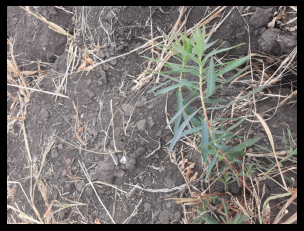

In [ ]:
img = Image.open("/content/weed_split/val/Molochai_lozniy/ce5b4e8f-3bdc-eae2-0581-877422077b87.jpg")
plt.axis("off")
plt.imshow(img);

In [ ]:
input = transform_test(img)

In [ ]:
input.size()

torch.Size([3, 224, 224])

In [ ]:
input.unsqueeze(0).size()

torch.Size([1, 3, 224, 224])

In [ ]:
model.eval()
with torch.no_grad():
  out = model(input.unsqueeze(0).to(DEVICE))

In [ ]:
out_vec = out.cpu().numpy()

In [ ]:
idx = np.argmax(out_vec)

In [ ]:
idx

16

In [ ]:
dm.test_set.classes[idx]

'Molochai_lozniy'

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/Наверх-&#x21A9-blue'></a>
</div>

___


# Полезные ссылки



  

- [pyTorch Lighning](https://www.pytorchlightning.ai/tutorials) - вспомогательная библиотка, которая помогает писать меньше кода для `pyTorch`
- [Albumentations](https://albumentations.ai/docs/) - одна из лучших библиотек для аугментаций
- [timm](https://github.com/rwightman/pytorch-image-models) - репозиторий зоопарка моделей `timm`
- [SOTA](https://paperswithcode.com/sota) - поиск решений State-of-the-Art
- [Обучение работы с captum](https://captum.ai/tutorials/Resnet_TorchVision_Interpret)




<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/Наверх-&#x21A9-blue'></a>
</div>

___
